# A Toy Model for Finding the "Ionization Fraction"

James Aguirre

First created 30 June 2021

Edited 21 July 2021

The idea here is to take the really simple "MNIST-like" images that show a Gaussian random field with some number pixels above a threshold set to the minimum value to simulate an "ionized region".  So we're adapting Paul's ML bootcamp notebook CNN architecture to regress the single number which is the fraction of pixels that are considered "ionized".

In [ ]:
%load_ext tensorboard

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scipy.ndimage as spimg

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten

In [4]:
toy_model = np.load('toy_models.npz')
nx, ny, ntrain = toy_model['training_data'].shape

In [5]:
training_data = toy_model['training_data'].T
labels = toy_model['labels']
training_data += toy_model['training_data'].T + 0.*np.random.normal(0, 0.2, size=toy_model['training_data'].T.shape)

In [6]:
training_data.shape

(10000, 32, 32)

In [7]:
example = training_data[10,:,:] #+ 
smex = spimg.gaussian_filter(example, 3)
noise = np.random.normal(0, 0.3, [32,32])
example_answer = labels[10]

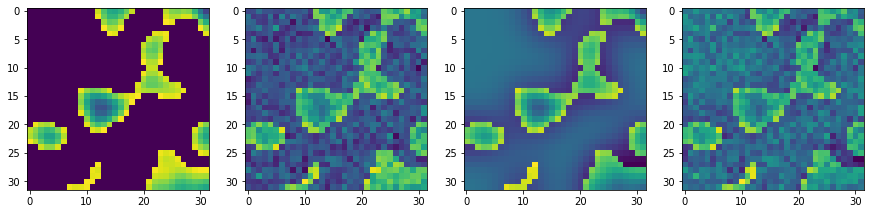

In [8]:
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(15,6))
ax[0].imshow(example)
ax[1].imshow(example + noise)
ax[2].imshow(example-smex)
ax[3].imshow(example-smex+noise)

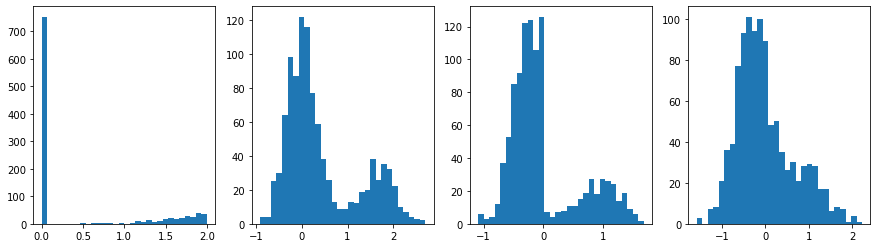

In [9]:
fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(15,4))
ax[0].hist(example.flatten(), bins=30);
ax[1].hist((example+noise).flatten(), bins=30);
ax[2].hist((example-smex).flatten(), bins=30);
ax[3].hist((example-smex+noise).flatten(), bins=30);

In [36]:
# make our model
model = Sequential()

# add layers
model.add(Conv2D(16, kernel_size=3, activation="relu", input_shape=(nx, ny, 1))) # was 64
model.add(Conv2D(8, kernel_size=3, activation="relu")) # was 32
model.add(Flatten())
model.add(Dense(1, activation="linear"))

In [37]:
X_train = training_data[0:8000,:,:].reshape(8000,nx,ny,1)
y_train = labels[0:8000]
X_test = training_data[8000:,:,:].reshape(2000,nx,ny,1)
y_test = labels[8000:]

## Visualize the model

In [38]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 16)        160       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 8)         1160      
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6273      
Total params: 7,593
Trainable params: 7,593
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
# Need to install pydot for this
#from tensorflow.keras.utils import plot_model
#plot_model(model, show_shapes=True, show_layer_names=True) #to_file="images/cnn_model_plot.png",

## Compile the Model

In [40]:
model.compile(optimizer="adam", loss="mape")#, metrics=["accuracy"])

## Training the Model
Now it's time to train it!

In [41]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [42]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, callbacks=[tensorboard_callback])

Epoch 1/10
250/250 [==============================] - 7s 27ms/step - loss: 29.9597 - val_loss: 7.0249
Epoch 2/10
250/250 [==============================] - 6s 24ms/step - loss: 5.8128 - val_loss: 5.5380
Epoch 3/10
250/250 [==============================] - 7s 27ms/step - loss: 4.6575 - val_loss: 4.9168
Epoch 4/10
250/250 [==============================] - 7s 28ms/step - loss: 4.0840 - val_loss: 4.1742
Epoch 5/10
250/250 [==============================] - 7s 27ms/step - loss: 3.9389 - val_loss: 3.9722
Epoch 6/10
250/250 [==============================] - 7s 26ms/step - loss: 3.6253 - val_loss: 5.3388
Epoch 7/10
250/250 [==============================] - 7s 27ms/step - loss: 3.7051 - val_loss: 3.4334
Epoch 8/10
250/250 [==============================] - 7s 27ms/step - loss: 3.7241 - val_loss: 3.2839
Epoch 9/10
250/250 [==============================] - 6s 24ms/step - loss: 3.1879 - val_loss: 3.2418
Epoch 10/10
250/250 [==============================] - 6s 25ms/step - loss: 2.9865 - val_l

Visualize https://www.tensorflow.org/tensorboard/get_started

In [43]:
#import os
#os.environ['TENSORBOARD_BINARY'] = '/lustre/aoc/projects/hera/jaguirre/anaconda3/envs/tau/bin/tensorboard'
# This is some serious horse muck here
#%tensorboard --logdir logs/fit

In [44]:
predictions_validation = model.predict(X_test).squeeze()
predictions_training = model.predict(X_train).squeeze()

In [45]:
def VisualizeTrainingValidation(true_train, pred_train, true_val, pred_val, 
                                xmin = None, ymin = None, xmax = None, ymax = None):

    if xmin is None:
        xmin = np.append(true_train, true_val).min()
    if xmax is None:
        xmax = np.append(true_train, true_val).max()
    if ymin is None:
        ymin = np.append(pred_train, pred_val).min()
    if ymax is None:
        ymax = np.append(pred_train, pred_val).max()
    

    fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(12,7))
    # -----
    ax[0,0].plot(true_train, pred_train, '.')
    ax[0,0].plot([xmin, xmax], [0,1])
    ax[0,0].set_title('Training')
    ax[0,0].set_ylabel('Prediction')
    ax[0,1].plot(true_val, pred_val, '.')
    ax[0,1].plot([0,1], [0,1])
    ax[0,1].set_title('Validation')
    # -----
    ax[1,0].plot(true_train, pred_train - true_train, '.', label='{:.4f}'.format(np.std(pred_train - true_train)))
    ax[1,0].axhline(0, color='orange')
    ax[1,0].legend()
    ax[1,0].set_ylabel('Absolute error')
    ax[1,1].plot(true_val, pred_val - true_val, '.', label='{:.4f}'.format(np.std(pred_val - true_val)))
    ax[1,1].axhline(0, color='orange')
    ax[1,1].legend()
    
    # -----
    ax[2,0].plot(true_train, (pred_train - true_train)/true_train, '.')
    ax[2,0].axhline(0, color='orange')
    ax[2,0].set_ylabel('Fractional Error')
    ax[2,0].set_xlabel('True Value')
    ax[2,0].set_ylim(-1,1)
    ax[2,1].plot(true_val, (pred_val - true_val)/true_val, '.')
    ax[2,1].axhline(0, color='orange')
    ax[2,1].set_xlabel('True Value')
    ax[2,1].set_ylim(-1,1)


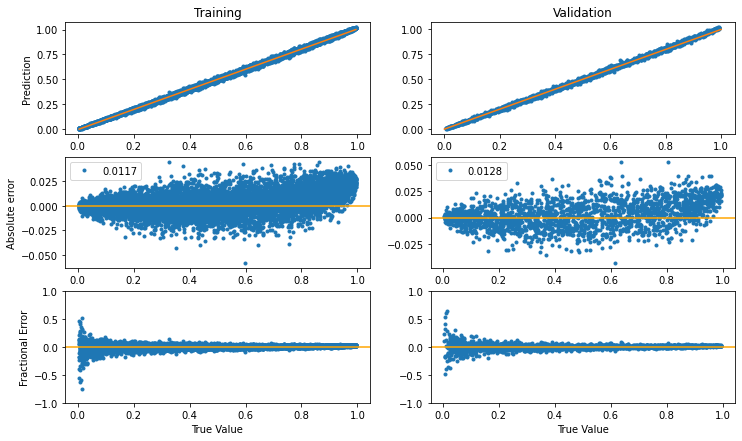

In [46]:
VisualizeTrainingValidation(y_train, predictions_training, y_test, predictions_validation)

In [21]:
y_train.shape, predictions_training.shape, y_test.shape, predictions_validation.shape

((8000,), (8000,), (2000,), (2000,))

To make use of TensorBoard, we add what's known as a `callback` to Keras's `fit` method on a Model object. Then from the command line, we open up TensorBoard and can visualize what's going on.

## Using TensorBoard
While that is running, open up a terminal, and navigate to the directory where these notebooks are. You should see a directory called `logs`. For example:
```bash
$ ls
Installation.ipynb  Lesson2.ipynb  Lesson4.ipynb  data    logs
Lesson1.ipynb       Lesson3.ipynb  Lesson5.ipynb  images

$ tensorboard --logdir=./logs
```
This will open up the TensorBoard program, which will give you access to quantities like the accuracy and loss values as a function of training epoch, as well as a visualization of the TensorFlow graph that's been generated by the model. There are a lot of nice features that TensorBoard has in it, so take a look!

In [35]:
ls logs/train

events.out.tfevents.1625106964.herapost001.12916.5747.v2  plugins/
events.out.tfevents.1625106965.herapost001.profile-empty
